In [1]:
import os, zipfile, random, json, collections, urllib, time

import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Obtenir le chemin du projet
project_path = os.getcwd()

# Créer un répertoire pour les données si ce n'est pas déjà fait
paths = {
    "data_dir": os.path.join(os.getcwd(), "data"),
    "train_images_dir": os.path.join(os.getcwd(), "data", "train2014"),
    "annotations_dir": os.path.join(os.getcwd(), "data", "annotations"),
    #JE SAIS QUE T AIME PAS ÇA MAIS VOILA DESOLE
    "train_images_zip": os.path.join(os.getcwd(), "data", "train2014.zip"),
    "annotations_zip": os.path.join(os.getcwd(), "data", "annotations_trainval2014.zip"),
    "annotation_file": os.path.join(os.getcwd(), "data", "annotations", "captions_train2014.json")
}

# Crée le répertoire si nécessaire
if not os.path.exists(paths["data_dir"]):
    os.makedirs(paths["data_dir"])

# URL du dataset COCO (images et annotations)
COCO_URLs = {
    "images": "http://images.cocodataset.org/zips/train2014.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
}

# Paramètres ajustables
epochs = 30
batch_size = 64
buffer_size = 1000
embedding_dim = 256
units = 512
top_k = 7500
vocab_size = top_k + 1

In [3]:
def download_and_extract(zip_path, extract_dir, url, description):
    # Téléchargement du fichier zip si non présent
    if not os.path.exists(zip_path):
        print(f"Téléchargement du dataset COCO {description} en cours...")
        urllib.request.urlretrieve(url, zip_path)
        print(f"Téléchargement des {description} terminé.")
    else:
        print(f"Le fichier zip des {description} existe déjà.")

    # Vérification et extraction si nécessaire
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            print(f"Extraction des fichiers {description} en cours...")
            zip_ref.extractall(os.path.dirname(extract_dir))
            print(f"Extraction des {description} terminée.")
    else:
        print(f"Les fichiers {description} ont déjà été extraits.")

    # Affichage du nombre de fichiers extraits
    if os.path.exists(extract_dir):
        extracted_files = os.listdir(extract_dir)
        print(f"{len(extracted_files)} fichiers extraits dans {extract_dir}")
    else:
        print(f"Erreur : le dossier d'extraction des {description} n'existe pas.")

# Téléchargement et extraction des images et annotations en générant les chemins à la volée
download_and_extract(
    paths["train_images_zip"],
    paths["train_images_dir"],
    COCO_URLs["images"],
    "images"
)

download_and_extract(
    paths["annotations_zip"],
    paths["annotations_dir"],
    COCO_URLs["annotations"],
    "annotations"
)

Le fichier zip des images existe déjà.
Extraction des fichiers images en cours...
Extraction des images terminée.
82783 fichiers extraits dans /Users/mohamed/Documents/FISE A5/z/livrable_3/data/train2014
Le fichier zip des annotations existe déjà.
Extraction des fichiers annotations en cours...
Extraction des annotations terminée.
6 fichiers extraits dans /Users/mohamed/Documents/FISE A5/z/livrable_3/data/annotations


In [4]:
def create_image_caption_mapping(annotation_file, image_dir):
    # Lire le fichier d'annotation JSON
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    
    # Dictionnaire pour associer chaque image à ses légendes
    image_path_to_caption = collections.defaultdict(list)

    # Parcourir chaque annotation
    for annotation in annotations['annotations']:
        # Ajouter les balises de début et de fin à chaque légende
        caption = f"<start> {annotation['caption']} <end>"
        
        # Construire le chemin de l'image correspondant
        image_id = annotation['image_id']
        image_filename = f'COCO_train2014_{image_id:012d}.jpg'
        image_path = os.path.join(image_dir, image_filename)
        
        # Associer la légende à l'image
        image_path_to_caption[image_path].append(caption)

    return image_path_to_caption

image_path_to_caption = create_image_caption_mapping(
    paths["annotation_file"], 
    paths["train_images_dir"]
)

In [5]:
def get_random_image_paths_and_captions(image_path_to_caption, num_samples=2000):
    # Prendre tous les chemins d'images
    image_paths = list(image_path_to_caption.keys())
    
    # Sélectionner un échantillon aléatoire d'images
    train_image_paths = random.sample(image_paths, num_samples)

    # Initialiser les listes pour les légendes et les chemins d'images dupliqués
    train_captions = []
    img_name_vector = []

    # Remplir les listes en fonction des annotations
    for image_path in train_image_paths:
        caption_list = image_path_to_caption[image_path]
        # Ajouter chaque légende dans train_captions
        train_captions.extend(caption_list)
        # Ajouter le chemin de l'image dupliqué selon le nombre d'annotations
        img_name_vector.extend([image_path] * len(caption_list))

    return img_name_vector, train_captions

img_name_vector, train_captions = get_random_image_paths_and_captions(image_path_to_caption, 2000)


10003 10003
<start> A bus traveling down the street next to a bunch of cars. <end>


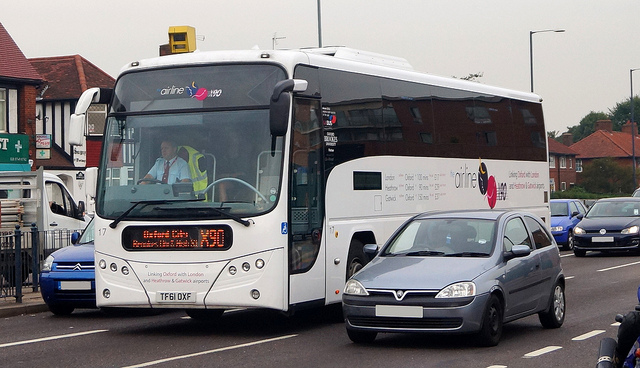

In [6]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

In [7]:
def create_image_feature_extractor():
    # Téléchargement du modèle InceptionV3 pré-entraîné sur ImageNet sans la couche supérieure
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

    # Récupérer l'entrée du modèle InceptionV3
    new_input = image_model.input

    # Récupérer la sortie de la dernière couche cachée (dense)
    hidden_layer = image_model.layers[-1].output

    # Créer un nouveau modèle qui extrait les caractéristiques denses des images
    image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

    return image_features_extract_model

image_features_extract_model = create_image_feature_extractor()

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, image_path

def save_image_features(batch_features, paths):
    for bf, p in zip(batch_features, paths):
        path_of_feature = p.numpy().decode("utf-8") 

        np.save(path_of_feature, bf.numpy())

# Pré-traitement des images
encode_train = sorted(set(img_name_vector))

# Créer un Dataset TensorFlow pour traiter les images par lots
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour extraire les caractéristiques des images
for img, path in tqdm(image_dataset):
    # Extraire les caractéristiques du batch actuel avec InceptionV3
    batch_features = image_features_extract_model(img)
    # Redimensionner les caractéristiques (16, 8, 8, 2048) en (16, 64, 2048)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    # Sauvegarder les caractéristiques extraites pour chaque image dans le batch
    save_image_features(batch_features, path)


100%|██████████| 125/125 [01:20<00:00,  1.54it/s]


In [9]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

def preprocess_captions(train_captions, top_k=5000):
    # Initialiser le tokenizer avec les paramètres spécifiques
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=top_k, 
        oov_token="<unk>", 
        filters=r'!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
        )
    
    # Construire le vocabulaire basé sur les légendes
    tokenizer.fit_on_texts(train_captions)

    # Ajouter un token spécial pour remplir les légendes courtes
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Convertir les légendes en séquences de tokens
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    # Remplir les séquences à la longueur maximale
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

    # Calculer la longueur maximale des séquences
    max_length = calc_max_length(train_seqs)

    return cap_vector, tokenizer, max_length

def save_tokenizer(tokenizer, save_path):
    tokenizer_json = tokenizer.to_json()
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    print(f'Tokenizer sauvegardé dans {save_path}.')

# Prétraitement des légendes d'entraînement
cap_vector, tokenizer, max_length = preprocess_captions(train_captions, top_k)

# Sauvegarder le tokenizer pour un usage ultérieur
tokenizer_save_path = os.path.join(os.getcwd(), 'tokenizer.json') #TODO: CHARLES CHANGE ÇA STP
save_tokenizer(tokenizer, tokenizer_save_path)

Tokenizer sauvegardé dans /Users/mohamed/Documents/FISE A5/z/livrable_3/tokenizer.json.


In [10]:
def create_image_caption_mapping(img_name_vector, cap_vector):
    img_to_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)
    
    return img_to_cap_vector

def split_dataset(img_to_cap_vector, split_ratio=0.8):
    # Récupérer les clés (chemins des images, sans doublons)
    img_keys = list(img_to_cap_vector.keys())
    random.shuffle(img_keys)  # Mélanger les clés

    # Diviser les indices selon le ratio défini
    slice_index = int(len(img_keys) * split_ratio)
    img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

    # Construire les listes d'entrainement et de validation
    img_name_train, cap_train = [], []
    img_name_val, cap_val = [], []

    # Boucle pour l'ensemble d'entraînement
    for imgt in img_name_train_keys:
        capt_len = len(img_to_cap_vector[imgt])
        img_name_train.extend([imgt] * capt_len)
        cap_train.extend(img_to_cap_vector[imgt])

    # Boucle pour l'ensemble de validation
    for imgv in img_name_val_keys:
        capv_len = len(img_to_cap_vector[imgv])
        img_name_val.extend([imgv] * capv_len)
        cap_val.extend(img_to_cap_vector[imgv])

    return img_name_train, cap_train, img_name_val, cap_val

# Association des images avec leurs légendes
img_to_cap_vector = create_image_caption_mapping(img_name_vector, cap_vector)

# Division du dataset en ensembles d'entraînement et de validation
img_name_train, cap_train, img_name_val, cap_val = split_dataset(img_to_cap_vector, split_ratio=0.8)

# Affichage des tailles des jeux d'entraînement et de validation
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

num_steps = len(img_name_train) // batch_size

In [11]:
# Les formes des vecteurs extraits de InceptionV3
features_shape = 2048
attention_features_shape = 64

def map_func(img_name, cap):
    img_path = img_name.decode('utf-8') + '.npy'
    if os.path.exists(img_path):
        img_tensor = np.load(img_path)
    else:
        raise FileNotFoundError(f"Le fichier {img_path} n'existe pas.")
    
    return img_tensor, cap

def create_dataset(img_names, captions, batch_size=batch_size, buffer_size=buffer_size):
    # Création du dataset à partir des images et des légendes
    dataset = tf.data.Dataset.from_tensor_slices((img_names, captions))

    # Utiliser map pour charger les fichiers numpy
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Mélanger les données et les diviser en batchs
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Création du dataset d'entraînement
dataset = create_dataset(img_name_train, cap_train)

In [12]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim, dropout_rate=0.5):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)  # Ajoute un Dropout ici
        return x

In [13]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, dropout_rate=0.5):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, features, hidden, training=False):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Ajout de Dropout sur les poids d'attention
        attention_weights = self.dropout(attention_weights, training=training)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [14]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # Remplacement de la couche GRU par LSTM
        self.lstm = tf.keras.layers.LSTM(self.units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

        # Couche dense qui aura pour entrée la sortie du LSTM
        self.fc1 = tf.keras.layers.Dense(self.units)
        # Dernière couche dense
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # L'attention est défini par un modèle à part
        context_vector, attention_weights = self.attention(features, hidden[0])

        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
        
        # Concaténation du vecteur de contexte et de l'embedding
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passage du vecteur concaténé à la LSTM
        output, hidden_state, cell_state = self.lstm(x, initial_state=hidden)

        # Couche dense après LSTM
        y = self.fc1(output)

        # Reshape du résultat
        y = tf.reshape(y, (-1, y.shape[2]))

        # Dernière couche dense pour obtenir la prédiction du vocabulaire
        y = self.fc2(y)

        return y, [hidden_state, cell_state], attention_weights

    def reset_state(self, batch_size):
        # Pour LSTM, initialiser deux états : hidden state et cell state
        return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

In [15]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)

In [16]:
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [17]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [18]:
checkpoint_path = os.path.abspath("data/checkpoints")

def setup_checkpoint(encoder, decoder, optimizer, max_to_keep=5):
    # Créer le checkpoint
    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=max_to_keep)
    
    start_epoch = 0
    
    # Restaurer le dernier checkpoint s'il existe
    if ckpt_manager.latest_checkpoint:
        start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
        print(f"Restoration du dernier checkpoint à l'époque {start_epoch}.")
        ckpt.restore(ckpt_manager.latest_checkpoint)
    else:
        print("Aucun checkpoint trouvé, entraînement à partir de zéro.")
    
    return ckpt_manager, start_epoch

ckpt_manager, start_epoch = setup_checkpoint(encoder, decoder, optimizer)


Aucun checkpoint trouvé, entraînement à partir de zéro.


In [19]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_score(real_caption, generated_caption):
    # Split les phrases en mots pour le calcul du BLEU
    reference = [real_caption.split()]  # La vérité terrain
    candidate = generated_caption.split()  # La légende générée

    # Calcul du score BLEU
    bleu_score = sentence_bleu(reference, candidate)

    return bleu_score

In [20]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialiser l'entrée du décodeur avec le token <start> pour chaque séquence
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:  # Calcul des gradients pour optimiser les poids du modèle
        # Encoder l'image (extraction des features avec l'encodeur)
        features = encoder(img_tensor)

        # Boucle sur chaque étape de la séquence (chaque mot)
        for i in range(1, target.shape[1]):
            # Prédiction du i-ème mot avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # Calcul de la perte pour cette étape (comparaison entre la vérité et la prédiction)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct est utilisé comme entrée pour la prochaine prédiction
            dec_input = tf.expand_dims(target[:, i], 1)

    # Calcul de la perte moyenne par séquence
    total_loss = loss / int(target.shape[1])

    # Liste des variables entraînables (encodeur et décodeur)
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # Calcul des gradients en fonction de la perte
    gradients = tape.gradient(loss, trainable_variables)
    
    # Application des gradients pour mettre à jour les poids du modèle
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [21]:
def train_model(epochs, start_epoch, dataset, num_steps, ckpt_manager):
    loss_plot = []

    for epoch in range(start_epoch, epochs):
        start = time.time()
        total_loss = 0

        # Barre de progression pour l'epoch en cours
        with tqdm(total=num_steps, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:

            # Parcourir les batches d'entraînement
            for batch, (img_tensor, target) in enumerate(dataset):
                # Effectuer une étape d'entraînement
                batch_loss, t_loss = train_step(img_tensor, target)
                total_loss += t_loss

                # Mise à jour de la barre de progression
                pbar.set_postfix({"Batch Loss": f"{batch_loss.numpy() / int(target.shape[1]):.4f}"})
                pbar.update(1)

            # Sauvegarder la perte moyenne pour l'epoch
            loss_plot.append(total_loss / num_steps)

            # Sauvegarder les checkpoints tous les 5 epochs
            if epoch % 5 == 0:
                ckpt_manager.save()
                print(f'Checkpoint sauvegardé à l\'epoch {epoch + 1}')

        # Afficher la perte moyenne et le temps pris pour l'epoch
        print(f'\nEpoch {epoch + 1} Loss {total_loss / num_steps:.6f}')
        print(f'Temps pris pour l\'epoch {epoch + 1}: {time.time() - start:.2f} secondes\n')

    return loss_plot

# Lancer l'entraînement
loss_plot = train_model(epochs, start_epoch, dataset, num_steps, ckpt_manager)

Epoch 1/30: 126batch [03:01,  3.79s/batch, Batch Loss=0.7664]                      2024-10-22 11:09:08.741816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 1/30: 126batch [03:01,  1.44s/batch, Batch Loss=0.7664]


Checkpoint sauvegardé à l'epoch 1

Epoch 1 Loss 1.243935
Temps pris pour l'epoch 1: 181.60 secondes



Epoch 2/30: 126batch [02:31,  1.14batch/s, Batch Loss=1.0096]                      2024-10-22 11:11:40.026604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 2/30: 126batch [02:31,  1.20s/batch, Batch Loss=1.0096]



Epoch 2 Loss 1.011716
Temps pris pour l'epoch 2: 151.23 secondes



Epoch 3/30: 126batch [02:37,  1.04batch/s, Batch Loss=0.7159]                      2024-10-22 11:14:17.848608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 3/30: 126batch [02:37,  1.25s/batch, Batch Loss=0.7159]



Epoch 3 Loss 0.881531
Temps pris pour l'epoch 3: 157.82 secondes



Epoch 4/30: 126batch [02:39,  1.09batch/s, Batch Loss=0.8200]                      2024-10-22 11:16:56.956367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4/30: 126batch [02:39,  1.26s/batch, Batch Loss=0.8200]



Epoch 4 Loss 0.791747
Temps pris pour l'epoch 4: 159.11 secondes



Epoch 5/30: 126batch [02:34,  1.07batch/s, Batch Loss=0.6602]                      2024-10-22 11:19:31.623884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 5/30: 126batch [02:34,  1.23s/batch, Batch Loss=0.6602]



Epoch 5 Loss 0.721428
Temps pris pour l'epoch 5: 154.67 secondes



Epoch 6/30: 126batch [02:36,  1.13batch/s, Batch Loss=0.8919]                      2024-10-22 11:22:07.862206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 6/30: 126batch [02:36,  1.24s/batch, Batch Loss=0.8919]


Checkpoint sauvegardé à l'epoch 6

Epoch 6 Loss 0.669774
Temps pris pour l'epoch 6: 156.29 secondes



Epoch 7/30: 126batch [02:29,  1.05batch/s, Batch Loss=0.5350]                      2024-10-22 11:24:37.903362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7/30: 126batch [02:29,  1.19s/batch, Batch Loss=0.5350]



Epoch 7 Loss 0.624433
Temps pris pour l'epoch 7: 149.99 secondes



Epoch 8/30: 126batch [02:31,  1.10batch/s, Batch Loss=0.5176]                      2024-10-22 11:27:09.843986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 8/30: 126batch [02:31,  1.21s/batch, Batch Loss=0.5176]



Epoch 8 Loss 0.577863
Temps pris pour l'epoch 8: 151.94 secondes



Epoch 9/30: 126batch [02:28,  1.15batch/s, Batch Loss=0.5548]                      2024-10-22 11:29:38.066393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 9/30: 126batch [02:28,  1.18s/batch, Batch Loss=0.5548]



Epoch 9 Loss 0.539982
Temps pris pour l'epoch 9: 148.22 secondes



Epoch 10/30: 126batch [02:25,  1.15batch/s, Batch Loss=0.6045]                      2024-10-22 11:32:03.352290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 10/30: 126batch [02:25,  1.15s/batch, Batch Loss=0.6045]



Epoch 10 Loss 0.501584
Temps pris pour l'epoch 10: 145.29 secondes



Epoch 11/30: 126batch [02:25,  1.15batch/s, Batch Loss=0.6920]                      2024-10-22 11:34:28.444398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 11/30: 126batch [02:25,  1.15s/batch, Batch Loss=0.6920]


Checkpoint sauvegardé à l'epoch 11

Epoch 11 Loss 0.466417
Temps pris pour l'epoch 11: 145.14 secondes



Epoch 12/30: 126batch [02:26,  1.14batch/s, Batch Loss=0.3948]                      2024-10-22 11:36:55.000185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 12/30: 126batch [02:26,  1.16s/batch, Batch Loss=0.3948]



Epoch 12 Loss 0.428355
Temps pris pour l'epoch 12: 146.51 secondes



Epoch 13/30: 126batch [02:32,  1.15batch/s, Batch Loss=0.2299]                      2024-10-22 11:39:27.394900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 13/30: 126batch [02:32,  1.21s/batch, Batch Loss=0.2299]



Epoch 13 Loss 0.390276
Temps pris pour l'epoch 13: 152.39 secondes



Epoch 14/30: 126batch [02:26,  1.13batch/s, Batch Loss=0.2243]                      2024-10-22 11:41:53.682757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 14/30: 126batch [02:26,  1.16s/batch, Batch Loss=0.2243]



Epoch 14 Loss 0.354713
Temps pris pour l'epoch 14: 146.29 secondes



Epoch 15/30: 126batch [02:25,  1.12batch/s, Batch Loss=0.4088]                      2024-10-22 11:44:18.928951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 15/30: 126batch [02:25,  1.15s/batch, Batch Loss=0.4088]



Epoch 15 Loss 0.323546
Temps pris pour l'epoch 15: 145.25 secondes



Epoch 16/30: 126batch [02:25,  1.13batch/s, Batch Loss=0.3199]                      2024-10-22 11:46:44.063419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 16/30: 126batch [02:25,  1.15s/batch, Batch Loss=0.3199]


Checkpoint sauvegardé à l'epoch 16

Epoch 16 Loss 0.293219
Temps pris pour l'epoch 16: 145.18 secondes



Epoch 17/30: 126batch [02:26,  1.06batch/s, Batch Loss=0.1069]                      2024-10-22 11:49:11.037098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 17/30: 126batch [02:26,  1.17s/batch, Batch Loss=0.1069]



Epoch 17 Loss 0.261813
Temps pris pour l'epoch 17: 146.93 secondes



Epoch 18/30: 126batch [02:33,  1.09batch/s, Batch Loss=0.3198]                      2024-10-22 11:51:44.487488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 18/30: 126batch [02:33,  1.22s/batch, Batch Loss=0.3198]



Epoch 18 Loss 0.229994
Temps pris pour l'epoch 18: 153.45 secondes



Epoch 19/30: 126batch [02:33,  1.08batch/s, Batch Loss=0.1764]                      2024-10-22 11:54:17.701807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 19/30: 126batch [02:33,  1.22s/batch, Batch Loss=0.1764]



Epoch 19 Loss 0.208971
Temps pris pour l'epoch 19: 153.21 secondes



Epoch 20/30: 126batch [02:33,  1.09batch/s, Batch Loss=0.2187]                      2024-10-22 11:56:51.651293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 20/30: 126batch [02:33,  1.22s/batch, Batch Loss=0.2187]



Epoch 20 Loss 0.182596
Temps pris pour l'epoch 20: 153.95 secondes



Epoch 21/30: 126batch [02:34,  1.08batch/s, Batch Loss=0.0914]                      2024-10-22 11:59:25.972949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 21/30: 126batch [02:34,  1.23s/batch, Batch Loss=0.0914]


Checkpoint sauvegardé à l'epoch 21

Epoch 21 Loss 0.166797
Temps pris pour l'epoch 21: 154.37 secondes



Epoch 22/30: 126batch [02:35,  1.07batch/s, Batch Loss=0.1238]                      2024-10-22 12:02:01.653442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 22/30: 126batch [02:35,  1.24s/batch, Batch Loss=0.1238]



Epoch 22 Loss 0.142799
Temps pris pour l'epoch 22: 155.63 secondes



Epoch 23/30: 126batch [02:35,  1.07batch/s, Batch Loss=0.1670]                      2024-10-22 12:04:36.923706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 23/30: 126batch [02:35,  1.23s/batch, Batch Loss=0.1670]



Epoch 23 Loss 0.131397
Temps pris pour l'epoch 23: 155.27 secondes



Epoch 24/30: 126batch [02:34,  1.08batch/s, Batch Loss=0.1741]                      2024-10-22 12:07:11.415495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 24/30: 126batch [02:34,  1.23s/batch, Batch Loss=0.1741]



Epoch 24 Loss 0.123230
Temps pris pour l'epoch 24: 154.49 secondes



Epoch 25/30: 126batch [02:33,  1.08batch/s, Batch Loss=0.0954]                      2024-10-22 12:09:45.094693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 25/30: 126batch [02:33,  1.22s/batch, Batch Loss=0.0954]



Epoch 25 Loss 0.115577
Temps pris pour l'epoch 25: 153.68 secondes



Epoch 26/30: 126batch [02:34,  1.08batch/s, Batch Loss=0.0969]                      2024-10-22 12:12:19.321179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 26/30: 126batch [02:34,  1.22s/batch, Batch Loss=0.0969]


Checkpoint sauvegardé à l'epoch 26

Epoch 26 Loss 0.103380
Temps pris pour l'epoch 26: 154.27 secondes



Epoch 27/30: 126batch [02:33,  1.08batch/s, Batch Loss=0.0945]                      2024-10-22 12:14:53.074914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 27/30: 126batch [02:33,  1.22s/batch, Batch Loss=0.0945]



Epoch 27 Loss 0.098269
Temps pris pour l'epoch 27: 153.71 secondes



Epoch 28/30: 126batch [02:33,  1.08batch/s, Batch Loss=0.0899]                      2024-10-22 12:17:27.003514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 28/30: 126batch [02:33,  1.22s/batch, Batch Loss=0.0899]



Epoch 28 Loss 0.095380
Temps pris pour l'epoch 28: 153.93 secondes



Epoch 29/30: 126batch [02:34,  1.09batch/s, Batch Loss=0.1096]                      2024-10-22 12:20:01.581097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 29/30: 126batch [02:34,  1.23s/batch, Batch Loss=0.1096]



Epoch 29 Loss 0.090627
Temps pris pour l'epoch 29: 154.58 secondes



Epoch 30/30: 126batch [02:33,  1.08batch/s, Batch Loss=0.0602]                      2024-10-22 12:22:34.946972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 30/30: 126batch [02:33,  1.22s/batch, Batch Loss=0.0602]


Epoch 30 Loss 0.090436
Temps pris pour l'epoch 30: 153.36 secondes



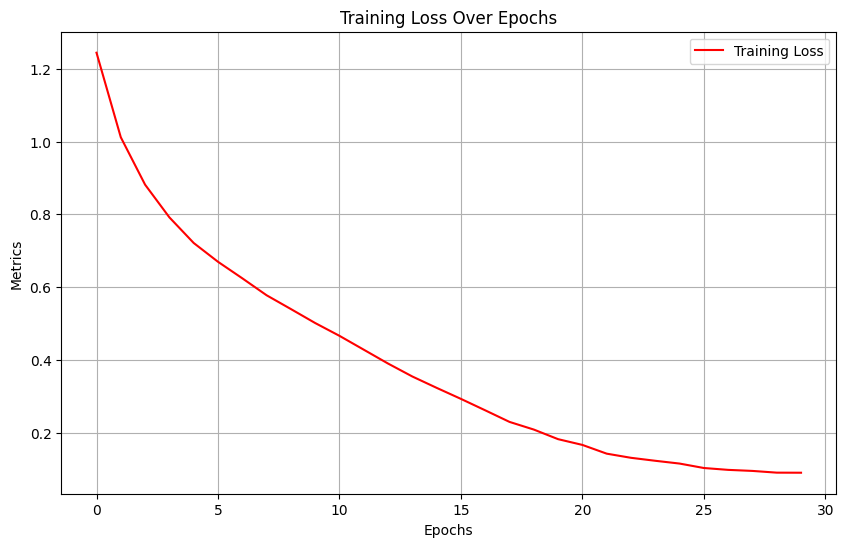

In [22]:
def plot_metrics(loss_plot):
    plt.figure(figsize=(10, 6))
    
    # Tracer la courbe de la perte
    plt.plot(loss_plot, label='Training Loss', color='r')
    
    # Tracer la courbe de la précision
    # plt.plot(accuracy_plot, label='Training Accuracy', color='g')
    
    # Tracer la courbe du score BLEU
    # plt.plot(bleu_plot, label='Training BLEU', color='b')

    # Ajouter des titres et labels
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training Loss Over Epochs')

    # Ajouter la grille pour faciliter la lecture
    plt.grid(True)

    # Ajouter la légende
    plt.legend()

    # Afficher le plot
    plt.show()

# Appeler la fonction pour afficher les courbes
plot_metrics(loss_plot)

In [23]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    # Charger et pré-traiter l'image
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Passer l'image à l'encodeur
    features = encoder(img_tensor_val)

    # Initialiser l'entrée du décodeur avec le token <start>
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # Prédire le mot suivant
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Sauvegarder les poids d'attention
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Sélectionner l'ID du mot prédit avec argmax pour des prédictions plus déterministes
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        result.append(tokenizer.index_word.get(predicted_id, '<unk>'))

        if tokenizer.index_word.get(predicted_id) == '<end>':
            attention_plot = attention_plot[:len(result), :]
            return result, attention_plot

        # Mettre à jour l'entrée pour le prochain mot
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    grid_size = int(np.ceil(np.sqrt(len_result)))

    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(grid_size, grid_size, l+1) 
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Image ID: 578
Real Caption: <start> several people with surf boards walking on rocks next to the ocean <end>
Prediction Caption: a group of people on a beach and mountains <end>


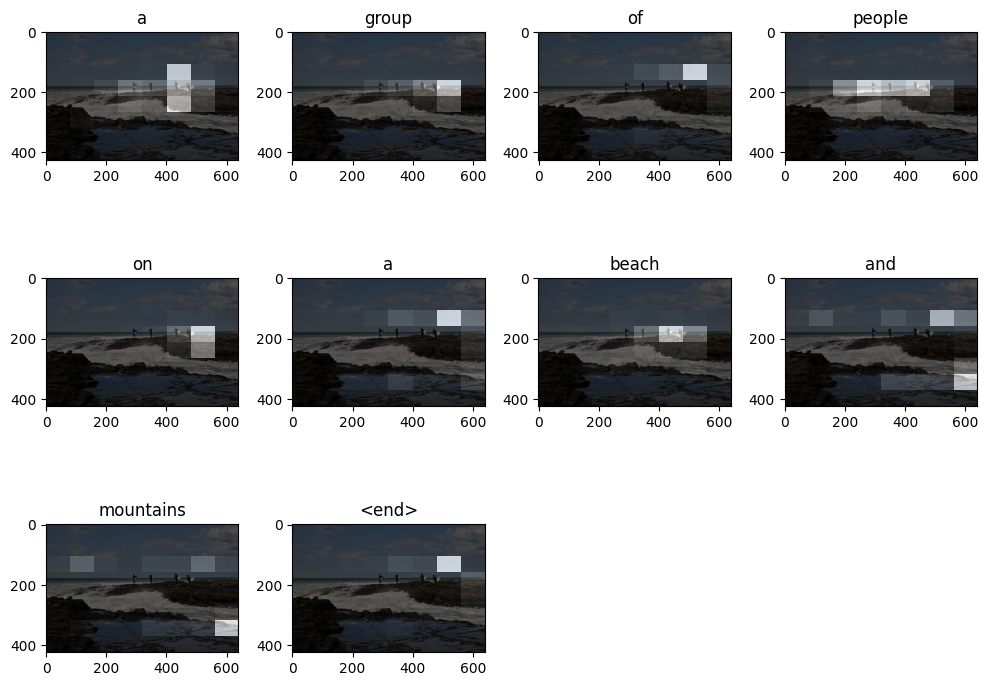

In [26]:
def display_random_annotation(img_name_val, cap_val, tokenizer, num_samples=1):
    for _ in range(num_samples):
        rid = np.random.randint(0, len(img_name_val))
        image = img_name_val[rid]

        # Générer la légende réelle
        real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

        # Prédire la légende avec le modèle
        result, attention_plot = evaluate(image)

        # Afficher la légende réelle et la légende prédite
        print(f"\nImage ID: {rid}")
        print(f"Real Caption: {real_caption}")
        print(f"Prediction Caption: {' '.join(result)}")

        # Visualiser l'attention
        plot_attention(image, result, attention_plot)

display_random_annotation(img_name_val, cap_val, tokenizer, num_samples=1)